<a href="https://colab.research.google.com/github/hyunseo318/ESAA_study/blob/main/%EB%B0%A9%ED%95%99%EC%8A%A4%ED%84%B0%EB%94%94_%EC%9E%90%EC%A0%84%EA%B1%B0_%EB%8C%80%EC%97%AC_%EC%88%98%EC%9A%94_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. 자전거 대여 수요 예측**
https://www.kaggle.com/c/bike-sharing-demand

날짜, 계절, 근무일 여부, 날씨, 온도, 체감 온도, 풍속 데이터를 활용하여 자전거 대여 수량 예측

- 문제 유형 : 회귀
- 평가 지표 : RMSLE
- 모델 : 랜덤 포레스트 회귀

##**6.1 경진대회 이해**

워싱턴 D.C 의 자전거 무인 대여 시스템 과거 기록을 기반으로 향후 자전거 대여 수요를 예측하는 대회
- 예측값이 범주형이 아니므로 회귀 문제

> 피처와 타깃값이란?
> - `피처(독립변수)` : 원하는 값을 예측하기 위해 활용하는 데이터
> - `타깃값(종속변수)` : 예측해야 할 값




##**6.2 경진대회 접속 방법 및 세부 메뉴**
###**Overview**
- Description : 경진대회 소개글
- Evaluation : 평가지표(RMSLE)

###**Data**
경진대회가 제공하는 데이터에 대해 설명해놓은 메뉴





##**6.3 탐색적 데이터 분석**



In [1]:
import numpy as np
import pandas as pd #판다스 임포트

data_path = '/content/drive/MyDrive/ESAA/study/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [2]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [6]:
#info - Dataframe 각 열의 결측값, 데이터타입
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### **피처 엔지니어링**
- raw data에서 찾기 어려운 경향, 공통점, 차이 분석
- 일부 데이터는 시각화하기에 적합하지 않은 형태일 수 있음 : `datetime`

  - 데이터 타입 = object(문자열)
  - 연도, 월, 일, 시간, 분, 초로 구성

In [8]:
#datetime의 100번째 원소

print(train['datetime'][100]) # datetime 100번째 원소
print(train['datetime'][100].split()) # 공백 기준으로 문자열 나누기
print(train['datetime'][100].split()[0]) # 날짜
print(train['datetime'][100].split()[1]) # 시간

2011-01-05 09:00:00
['2011-01-05', '09:00:00']
2011-01-05
09:00:00


In [9]:
# 날짜 문자열을 연도, 월, 일로 나누기
print(train['datetime'][100].split()[0]) # 날짜
print(train['datetime'][100].split()[0].split("-")) #'-' 기준으로 문자열 나누기
print(train['datetime'][100].split()[0].split("-")[0]) #연도
print(train['datetime'][100].split()[0].split("-")[1]) #월
print(train['datetime'][100].split()[0].split("-")[2]) #일

2011-01-05
['2011', '01', '05']
2011
01
05


In [10]:
# 시간 문자열을 시, 분, 초로 나누기
print(train['datetime'][100].split()[1]) # 시간
print(train['datetime'][100].split()[1].split(":")) #':' 기준으로 문자열 나누기
print(train['datetime'][100].split()[1].split(":")[0]) #시간
print(train['datetime'][100].split()[1].split(":")[1]) #분
print(train['datetime'][100].split()[1].split(":")[2]) #초

09:00:00
['09', '00', '00']
09
00
00


`apply() `
- DataFrame의 데이터를 일괄 가공
- lambda 함수와 함께 사용
- lambda 함수를 DataFrame 축을 따라 적용하는 기능

In [11]:
# apply() 함수로 날짜, 연도, 월, 일, 시, 분, 초 피처 생성

train['date'] = train['datetime'].apply(lambda x: x.split()[0]) #날짜 피처 생성

#연도, 월, 일, 시, 분, 초 피처를 차례로 생성
train['year'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[0])
train['month'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[1])
train['day'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[2])
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train['minute'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[1])
train['second'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[2])

In [12]:
# 요일 피처 생성

from datetime import datetime #datetime 라이브러리 임포트
import calendar

print(train['date'][100]) #날짜
print(datetime.strptime(train['date'][100], '%Y-%m-%d')) #datetime 타입으로 변경
#정수로 요일 반환
print(datetime.strptime(train['date'][100],'%Y-%m-%d').weekday())
#문자열로 요일 반환
print(calendar.day_name[datetime.strptime(train['date'][100],'%Y-%m-%d').weekday()])

2011-01-05
2011-01-05 00:00:00
2
Wednesday


In [13]:
train['weekday'] = train['date'].apply(
    lambda dateString : 
    calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()]
)

In [14]:
#범주형 데이터 -> 시각화 시 의미가 잘 드러나도록 변환
train['season'] = train['season'].map({1:'Spring',2:'Summer',3:'Fall',4:'Winter'})
train['weather'] = train['weather'].map({1:'Clear',2:'Mist, Few clouds',3:'Light Snow, Rain, Thunderstorm',4:'Heavy Rain, Thunderstorm, Snow, Fog'})

In [15]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


- 추후 date, month 피처 제거
  - 지나치게 세분화 된 피처를 더 큰 분류로 묶으면 성능이 좋아짐 (month -> season)

### **데이터 시각화**


`matplotlib` : 파이썬으로 데이터를 시각화할 때 표준처럼 사용되는 라이브러리

`seaborn` : matplotlib에 고수준 인터페이스를 덧씌운 라이브러리

In [24]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# matplotlib이 그린 그래프를 주피터 노트북에서 바로 출력

####**분포도**
`분포도(Distribution plot)` : 수치형 데이터의 집계 값을 나타내는 그래프


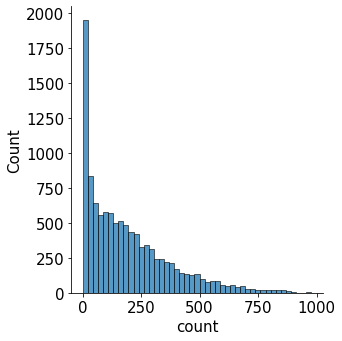

In [20]:
mpl.rc('font',size=15) #폰트 크기를 15로 설정
sns.displot(train['count']) #분포도 출력

회귀 모델이 좋은 성능을 내려면 데이터가 정규분포를 따라야 함 : 로그변환
- 타깃 값을 log(count)로 변환 후 마지막에는 지수변환하여 count로 복원

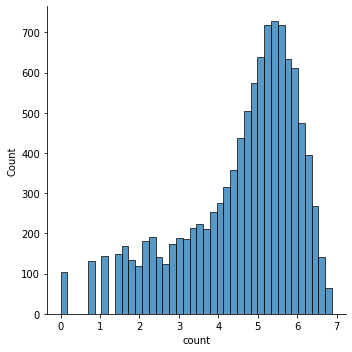

In [25]:
sns.displot(np.log(train['count']))

####**막대 그래프**
범주형 데이터 : seaborn의 barplot()

In [ ]:
#연도,월,일,시,분,초별로 여섯가지의 평균 대여 수량


Step 1. m행 n열 Figure 준비하기

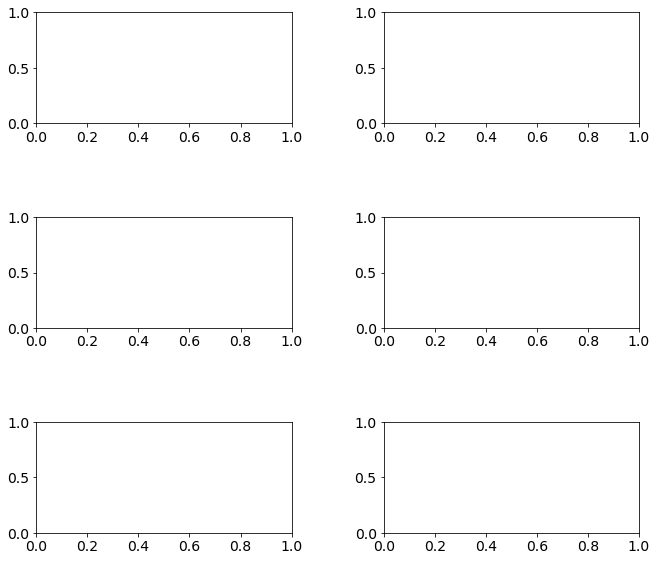

In [26]:
mpl.rc('font',size = 14) #폰트 크기 설정
mpl.rc('axes',titlesize = 15) #각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2) #3행 2열 Figure 생성
plt.tight_layout() # 그래프 사이에 여백 확보
figure.set_size_inches(10,9) #전체 Figure 크기를 10x9인치로 설정

In [27]:
axes

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f43cac5a4c0>,
      dtype=object)

In [29]:
axes.shape

(3, 2)

Step 2. 각 축에 서브플롯 할당

In [30]:
sns.barplot(x='year', y='count', data=train, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2, 0])
sns.barplot(x='second', y='count', data=train, ax=axes[2, 1])

Step 3. (선택)세부 설정

In [33]:
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Rental amounts by year')
axes[0, 1].set(title='Rental amounts by month')
axes[1, 0].set(title='Rental amounts by day')
axes[1, 1].set(title='Rental amounts by hour')
axes[2, 0].set(title='Rental amounts by minute')
axes[2, 1].set(title='Rental amounts by second')

# 3-2 : 1행에 위치한 서브플롯들의 x축 라벨 90도 회전
axes[1, 0].tick_params(axis='x', labelrotation=90)
axes[1, 1].tick_params(axis='x', labelrotation=90)

전체 코드

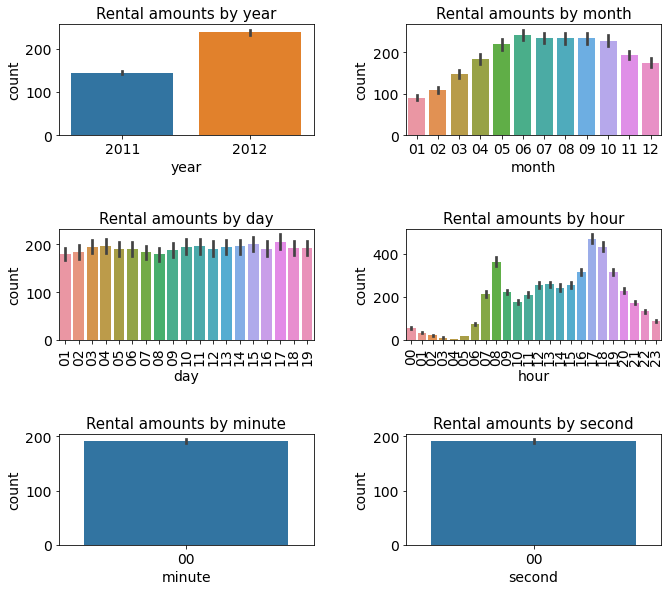

In [32]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=14)       # 폰트 크기 설정
mpl.rc('axes', titlesize=15)  # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2) # 3행 2열 Figure 생성 
plt.tight_layout()            # 그래프 사이에 여백 확보 
figure.set_size_inches(10, 9) # 전체 Figure 크기를 10x9인치로 설정 

# 스텝 2 : 각 축에 서브플롯 할당
# 각 축에 연도, 월, 일, 시간, 분, 초별 평균 대여 수량 막대 그래프 할당
sns.barplot(x='year', y='count', data=train, ax=axes[0, 0])
sns.barplot(x='month', y='count', data=train, ax=axes[0, 1])
sns.barplot(x='day', y='count', data=train, ax=axes[1, 0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1, 1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2, 0])
sns.barplot(x='second', y='count', data=train, ax=axes[2, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Rental amounts by year')
axes[0, 1].set(title='Rental amounts by month')
axes[1, 0].set(title='Rental amounts by day')
axes[1, 1].set(title='Rental amounts by hour')
axes[2, 0].set(title='Rental amounts by minute')
axes[2, 1].set(title='Rental amounts by second')

# 3-2 : 1행에 위치한 서브플롯들의 x축 라벨 90도 회전
axes[1, 0].tick_params(axis='x', labelrotation=90)
axes[1, 1].tick_params(axis='x', labelrotation=90)

####**박스플롯**
범주형 데이터에 따른 수치형 데이터 정보를 나타내는 그래프

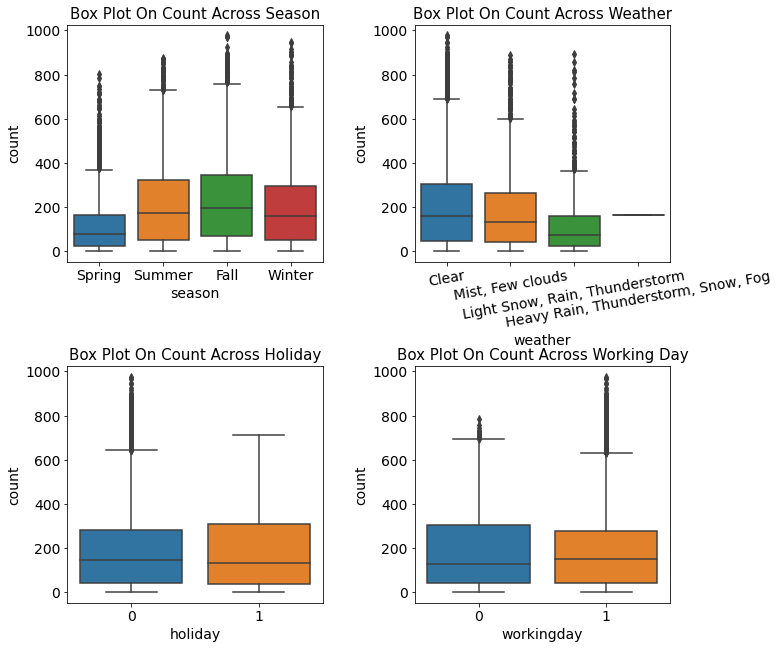

In [34]:
# 스텝 1 : m행 n열 Figure 준비
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(10, 10)

# 스텝 2 : 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일별 대여 수량 박스플롯
sns.boxplot(x='season', y='count', data=train, ax=axes[0, 0])
sns.boxplot(x='weather', y='count', data=train, ax=axes[0, 1])
sns.boxplot(x='holiday', y='count', data=train, ax=axes[1, 0])
sns.boxplot(x='workingday', y='count', data=train, ax=axes[1, 1])

# 스텝 3 : 세부 설정
# 3-1 : 서브플롯에 제목 달기
axes[0, 0].set(title='Box Plot On Count Across Season')
axes[0, 1].set(title='Box Plot On Count Across Weather')
axes[1, 0].set(title='Box Plot On Count Across Holiday')
axes[1, 1].set(title='Box Plot On Count Across Working Day')

# 3-2 : x축 라벨 겹침 해결
axes[0, 1].tick_params('x', labelrotation=10) # 10도 회전

1) 계절별 대여 수량 
- 봄에 가장 적고, 가을에 가장 많음

2) 날씨별 대여 수량
- 날씨가 좋을 때 수량이 가장 많고, 안좋을수록 수량이 적다.
- 폭우, 폭설이 내리는 날씨에는 대여 수량이 거의 없음

3) 공휴일 여부에 따른 대여 수량
- 0 : 공휴일이 아님, 1 : 공휴일
- 중앙값은 거의 비슷하나 공휴일이 아닌 경우 이상치가 많음

4) 근무일 여부에 따른 대여 수량
- 근무일일 때 이상치가 많음 ( 공휴일과 주말을 뺀 나머지 날 )

####**포인트 플롯**

범주형 데이터에 따른 수치형 데이터의 평균과 신뢰구간을 점과 선으로 표시

- 막대그래프와 동일한 정보를 제공하지만, 한 화면에 여러 그래프를 그려 서로 비교해보기에 더 적합함

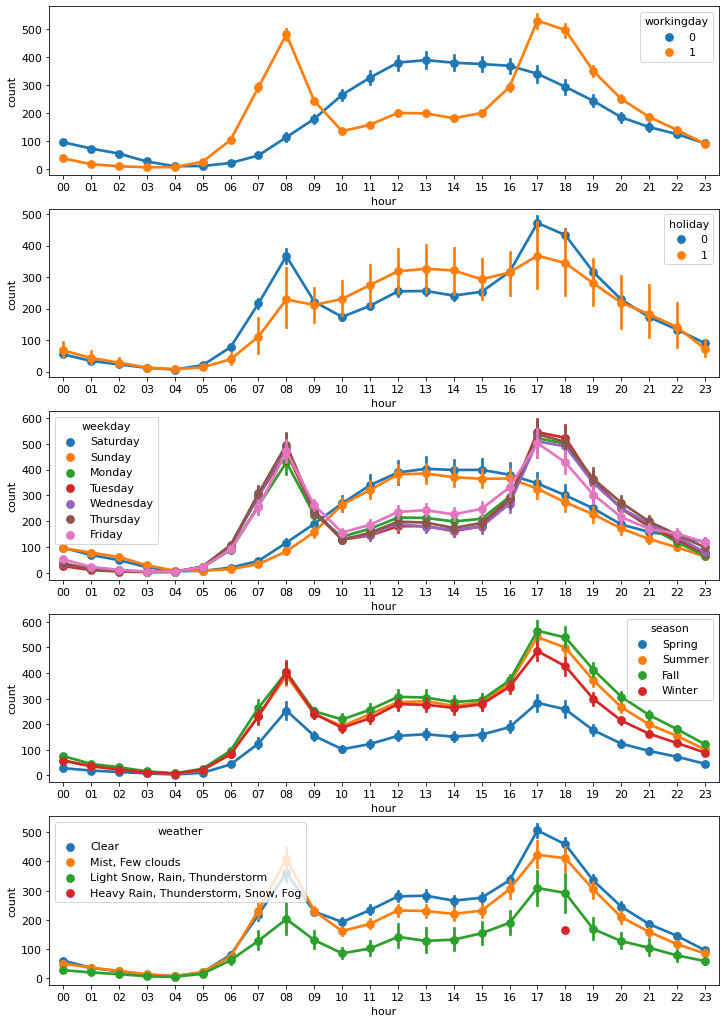

In [35]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5) # 5행 1열
figure.set_size_inches(12, 18)

# 스텝 2 : 서브플롯 할당
# 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량 포인트플롯
sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[4]);

1) 근무일에는 출퇴근시간에 대여 수량이 많고 쉬는 날에는 오후 12~2시에 가장 많다.

2)3) 공휴일 여부, 요일에 따른 포인트플롯도 비슷한 양상을 보임.

4) 계절에 따른 시간대별 대여수량은 가을에 가장 많고 봄에 가장 적음.

5) 날씨가 좋을 때 대여량이 가장 많음. 
- 폭우, 폭설이 내릴 때 18시 대여 건수(이상치)는 제거하는 것이 모델 성능 향상에 도움을 줌.

####**회귀선을 포함한 산점도 그래프**
수치형 데이터 간 상관관계를 파악하는 데 사용

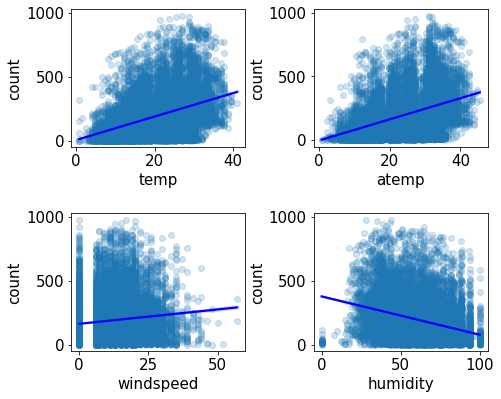

In [36]:
# 스텝 1 : m행 n열 Figure 준비
mpl.rc('font', size=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(7, 6)

# 스텝 2 : 서브플롯 할당
# 온도, 체감 온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(x='temp', y='count', data=train, ax=axes[0, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='atemp', y='count', data=train, ax=axes[0, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1, 0], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'})
sns.regplot(x='humidity', y='count', data=train, ax=axes[1, 1], 
            scatter_kws={'alpha': 0.2}, line_kws={'color': 'blue'});

1)2) 온도와 체감 온도가 높을수록 대여 수량이 많음

4) 습도는 낮을수록 대여를 많이 함

- 대여 수량은 추울 때보다 따뜻할 때 많고, 습할 때보다 습하지 않을 때 많음

3) 풍속이 셀수록 대여 수량이 많음 : 직관과 다름
- windspeed 피처에 결측값이 많기 때문
- 풍속이 0인 데이터
- **결측값 대체하거나 피처 자체를 삭제**

####**히트맵**
수치형 데이터끼리의 상관관계 파악

In [37]:
train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


조합이 많아 어느 피처들의 관계가 깊은지 한눈에 들어오지 않는다 

`히트맵(heatmap())` : 데이터 간 관계를 색상으로 표현하여, 여러 데이터를 한눈에 비교하기에 좋음


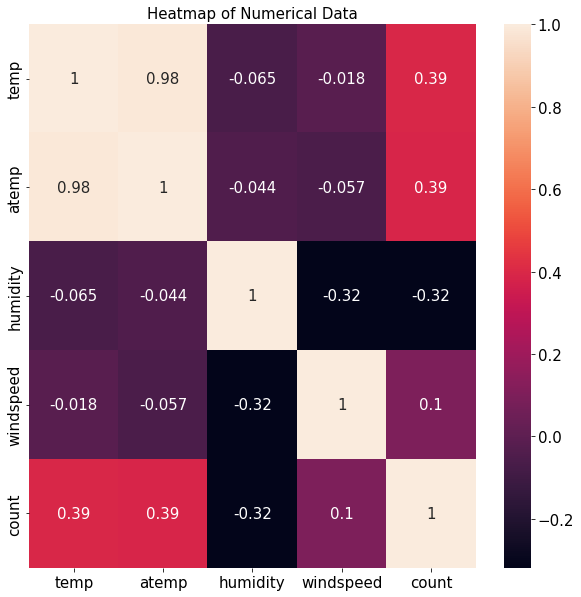

In [38]:
# 피처 간 상관관계 매트릭스
corrMat = train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr() 
fig, ax= plt.subplots() 
fig.set_size_inches(10, 10)
sns.heatmap(corrMat, annot=True) # 상관관계 히트맵 그리기
ax.set(title='Heatmap of Numerical Data');

corr() 함수로 구한 상관관계 매트릭스 corrMat를 heatmap() 함수에 인자로 넣어주면 됨.

`annot=True` : 상관계수가 숫자로 표시

---

온도(temp)와 대여 수량(count)간 상관계수는 0.39, 양의 상관관계
- 온도가 높을수록 대여 수량이 많다.

습도(humidity)와 대여 수량은 음의 상관관계
- 습도가 낮을수록 대여 수량이 많다.

풍속(windspeed)과 대여 수량은 0.1, 매우 약한 상관관계
- 대여 수량 예측에 별 도움을 주지 못할 것, 피처 제거

## **6.4 베이스라인 모델**

베이스라인 모델 : 뼈대가 되는 가장 기본적인 모델을 의미


```
데이터 불러오기 -> (기본적인) 피처 엔지니어링 -> 평가지표 계산 함수 작성 -> 모델 훈련 -> 성능 검증 -> 제출
```

In [40]:
import pandas as pd
# 데이터 경로
data_path = '/content/drive/MyDrive/ESAA/study/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

### **6.4.1 피처 엔지니어링**
데이터를 변환하는 작업
  - 훈련 데이터, 테스트데이터에 공통으로 반영해야 하므로 두 데이터를 합쳤다가 끝나면 나눠줌

####**이상치 제거**
weather 가 4인 데이터(폭우, 폭설이 내리는 날 저녁 6시 대여)는 이상치

In [41]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

####**데이터 합치기**
concat() : 축을 따라 이어붙일 수 있음
- 훈련데이터 10886행, 테스트 데이터 6493행
- 합치면 17379행, 하나 제거했으니 17378행

In [42]:
all_data_temp = pd.concat([train, test])
all_data_temp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [43]:
#원래 데이터 인덱스 무시하고 이어붙임
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


####**파생 피처(변수)추가**

- datetime 피처는 여락지 정보의 혼합체이므로 각각을 분리해 year, month, day, hour, minute, second 피처를 생성할 수 있음.
- datetime에 숨어있는 또 다른 정보인 요일(weekday) 피처 추가



In [44]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

- 훈련 데이터는 매달 1일부터 19일까지의 기록이고, 테스트데이터는 매달 20일부터 월말까지의 기록이므로 day 피처는 사용할 필요 없음
- minute와 second 피처도 모든 기록에서 값이 같으므로 예측에 사용할 필요 없음

-> day, minute, second는 피처로 생성하지 않음



####**필요 없는 피처 제거**
- casual, registered 피처는 테스트 데이터에 없는 피처이므로 제거
- datetime 피처는 인덱스 역할이고, date 피처가 갖는 정보는 다른 피처들에도 담겨 있으므로 datetime, date 피처 필요없음
- season 피처가 month의 대분류 성격이므로 제거
- windspeed 피처도 타깃값과 상관관계가 약해서 제거

In [45]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']

all_data = all_data.drop(drop_features, axis=1)


**`피처 선택`** : 모델링 시 데이터의 특징을 잘 나타내는 주요 피처만 선택하는 작업
- 타깃값 예측과 관련 없는 피처가 많다면 오히려 예측 성능이 떨어짐
- EDA, feature importance, 상관관계 매트릭스 등을 활용해 종합적으로 판단

####**데이터 나누기**

In [46]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

타깃값이 있으면 훈련데이터, 아니면 테스트 데이터
- `all_data['count']` 가 null 이 아니면 훈련 데이터



In [47]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


###**6.4.2 평가지표 계산 함수 작성**



In [49]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output 

###**6.4.3 모델 훈련**

In [50]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

In [51]:
log_y = np.log(y)  # 타깃값 로그변환
linear_reg_model.fit(X_train, log_y) # 모델 훈련

LinearRegression()

- 훈련 : 피처(독립변수)와 타깃값(종속변수)이 주어졌을 때 최적의 가중치(회귀계수)를 찾는 과정
- 예측 : 최적의 가중치를 아는 상태(훈련된 모델)에서 새로운 독립변수(데이터)가 주어졌을 때 타깃값을 추정하는 과정

---

- 탐색적 데이터 분석 : 예측에 도움이 될 피처를 추리고, 적절한 모델링 방법을 탐색하는 과정
- 피처 엔지니어링 : 추려진 피처들을 훈련에 적합하도록, 성능 향상에 도움되도록 가공하는 과정

###**6.4.4 모델 성능 검증**

In [52]:
preds = linear_reg_model.predict(X_train)

In [53]:
print (f'선형회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

선형회귀의 RMSLE 값 : 1.0205


###**6.4.5 예측 및 결과 제출**
1. 테스트 데이터로 예측한 결과를 이용해야 한다. 앞서 모델 성능 검증 과정에서는 RMSLE 값을 구해보고자 훈련데이터를 이용
2. 예측한 값에 지수변환을 해주어야 함. 현재 예측값이 count가 아니라 log(count)이므로.

In [54]:
linearreg_preds = linear_reg_model.predict(X_test) # 테스트 데이터로 예측

submission['count'] = np.exp(linearreg_preds)    # 지수변환
submission.to_csv('submission.csv', index=False) # 파일로 저장

##**6.5 성능개선 1 : 릿지 회귀 모델**

릿지 회귀 모델 : L2 규제를 적용한 선형 회귀 모델
  - 규제 : 모델이 훈련 데이터에 과대적합 되지 않도록 하는 방법
  - 성능이 좋은 편은 아님, 잘 쓰지 않는다.

성능 개선 과정


```
데이터 불러오기 -> 피처 엔지니어링 -> 평가지표 계산 함수 작성 -> 하이퍼파라미터 최적화(모델 훈련) -> 성능 검증 -> 제출
```
- 하이퍼파라미터 최적화
  1. 모델 생성(릿지 회귀)
  2. 그리드서치 객체 생성
  3. 훈련(그리드서치)



###**6.5.1 하이퍼파라미터 최적화(모델 훈련)**

####**모델 생성**

In [55]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

####**그리드서치 객체 생성**
1. 비교 검증해 볼 하이퍼파라미터 값 목록
2. 대상 모델
3. 교차 검증용 평가 수당(평가 함수)

In [56]:
# 하이퍼 파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,   # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer,    # 평가지표
                                      cv=5)                    # 교차검증 분할 수

In [57]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [58]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


###**6.5.2 성능 검증**

In [59]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train) 

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}') 

릿지 회귀 RMSLE 값 : 1.0205


##**6.6 성능개선 2 : 라쏘 회귀 모델**


###**6.6.1 하이퍼파라미터 최적화(모델 훈련)**

In [60]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()
# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}
# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


###**6.6.2 성능 검증**

In [61]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


##**6.7 성능개선 3 : 랜덤 포레스트 회귀 모델**
훈련 데이터를 랜덤하게 샘플링한 모델 n개를 각각 훈련하여 결과를 평균하는 방법


###**6.7.1 하이퍼파라미터 최적화(모델 훈련)**

In [62]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()
# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)
# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


- `random_state` : 랜덤 시드값, 값을 명시하면 코드를 다시 실행해도 같은 결과를 얻을 수 있음
-` n_estimators` : 결정 트리 개수

###**6.7.2 성능 검증**

In [63]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1127


###**6.7.3 예측 및 결과 제출**

- 랜덤 포레스트 회귀 모델의 성능이 가장 좋았음
- 훈련데이터, 테스트 데이터의 분포가 비슷함 : 과대 적합 문제가 상대적으로 적기 때문에 훈련 데이터에서 성능이 좋다면 테스트 데이터에서도 좋을 가능성이 크다.

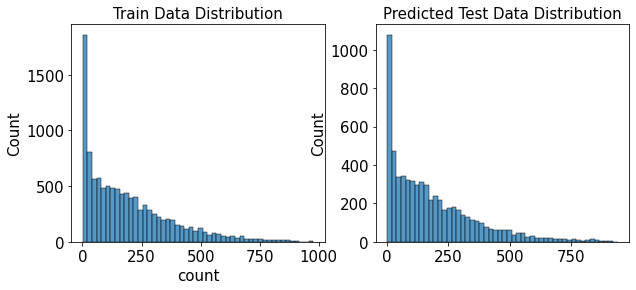

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [66]:
submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False)

---
평가 점수 : 0.39567, 상위 6%